<a href="https://colab.research.google.com/github/Jonathan-Chia/portfolio/blob/main/medical_abstract/organize_medical_abstracts_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Organizing Medical Abstracts using Natural Language Processing

The purpose of this notebook is to replicate an NLP model from [Neural networks for joint sentence classification in medical paper abstracts](https://arxiv.org/pdf/1612.05251.pdf) to make reading medical abstracts easier through labelling sentences into 5 categories:

* Background
* Objective
* Methods
* Results
* Conclusion

### Model Input
For example, can we train an NLP model which takes the following input (note: the following sample has had all numerical symbols replaced with "@"):

To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ). A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks. Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers. Pain was assessed using the visual analog pain scale ( @-@ mm ). Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD )., Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured. There was a clinically relevant reduction in the intervention group compared to the placebo group for knee pain , physical function , PGA , and @MWD at @ weeks. The mean difference between treatment arms ( @ % CI ) was @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; and @ ( @-@ @ ) , p < @ , respectively. Further , there was a clinically relevant reduction in the serum levels of IL-@ , IL-@ , TNF - , and hsCRP at @ weeks in the intervention group when compared to the placebo group. These differences remained significant at @ weeks. The Outcome Measures in Rheumatology Clinical Trials-Osteoarthritis Research Society International responder rate was @ % in the intervention group and @ % in the placebo group ( p < @ ). Low-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain , better physical function , and attenuation of systemic inflammation in older patients with knee OA ( ClinicalTrials.gov identifier NCT@ ).

### Model output
And returns the following output:

['###24293578\n',

 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',

 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',

 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',

 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',

 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',

 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .\n',

 'RESULTS\tThere was a clinically relevant reduction in the intervention group compared to the placebo group for knee pain , physical function , PGA , and @MWD at @ weeks .\n',

 'RESULTS\tThe mean difference between treatment arms ( @ % CI ) was @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; and @ ( @-@ @ ) , p < @ , respectively .\n',

 'RESULTS\tFurther , there was a clinically relevant reduction in the serum levels of IL-@ , IL-@ , TNF - , and hsCRP at @ weeks in the intervention group when compared to the placebo group .\n',

 'RESULTS\tThese differences remained significant at @ weeks .\n',

 'RESULTS\tThe Outcome Measures in Rheumatology Clinical Trials-Osteoarthritis Research Society International responder rate was @ % in the intervention group and @ % in the placebo group ( p < @ ) .\n',

 'CONCLUSIONS\tLow-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain , better physical function , and attenuation of systemic inflammation in older patients with knee OA ( ClinicalTrials.gov identifier NCT@ ) .\n',
 '\n']

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-251a302f-9da4-5a3a-e284-e934a3b01a03)


## Get the data
Data is from [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071)

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PubMed dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


It's already been split into train, test, valid sets. Nice.



In [ ]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess and Visualize the Data

In [ ]:
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list

  See https://realpython.com/read-write-files-python/ for resource
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

So the labels are separated by tabs, and each abstract is separated by a number

In [ ]:
len(train_lines)

210040

Hmm... let's turn this into a list of dictionaries?

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': 'Emotional eating is associated with overeating and the development of obesity. \n'
   'total_lines': 11},
   ...]
```

### Preprocessing Function

Steps:

1. Remove all the '\n'
2. Split the lines by abstract ID number? Or have a while loop that resets the total_lines counter each time we see a ###? Or we can remove abstract ID's and when we see a plain '\n' then we reset the counter 
3. Split each text line by tab and put the first part into `target` and second part into `text`


In [ ]:
# let's try messing around with two abstracts
two_abstracts = train_lines[:27]

In [ ]:
if '#' in two_abstracts[0]:
  print('success')

success


In [ ]:
two_abstracts[1].split('\t')

['OBJECTIVE',
 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n']

In [ ]:
# drafting what I think should happen in the function
list_of_dictionaries = list()
for line in two_abstracts:
  if line.startswith('###'):
    abstract = []
  elif line.startswith('\n'):
    total_lines=len(abstract)
    for i, line in enumerate(abstract):
      split_line = line.split('\t')
      target = split_line[0]
      text = split_line[1]
      dictionary = {'line_number': i,
                    'target': target,
                    'text': text,
                    'total_lines': total_lines-1}
      list_of_dictionaries.append(dictionary)
  else:
    abstract.append(line)

In [ ]:
list_of_dictionaries[:5]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'Secondary outcome measures

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # instead of '\n'
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 540 ms, sys: 121 ms, total: 661 ms
Wall time: 668 ms


### Visualize

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


Is dataset balanced?

In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

Should be somewhat okay - objective will probably have the worst accuracy

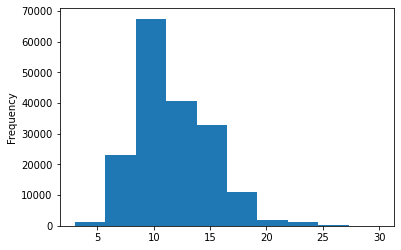

In [ ]:
train_df.total_lines.plot.hist();

### Get lists of sentences

In [ ]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels

In [ ]:
# One hot encoding
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# Label encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Baseline Model - Naive Bayes with Tfidf

Explanation of Tfidf: https://monkeylearn.com/blog/what-is-tf-idf/

Explanation of Naive Bayes: https://heartbeat.comet.ml/understanding-naive-bayes-its-applications-in-text-classification-part-1-ec9caea4baae

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()),
                    ('clf', MultinomialNB()) # clf = classifier
])

In [ ]:
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels_encoded)
baseline_score # accuracy

0.7218323844829869

72% accuracy is pretty good for a baseline! 


In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
# Download helper functions script from zero-to-mastery tensorflow github
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-23 20:28:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-23 20:28:28 (85.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import calculate_results helper function
from helper_functions import calculate_results

# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 1: Conv1D with token embeddings

### Tokenization

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# use the default textvectorization parameter
text_vectorizer = TextVectorization(max_tokens=None, 
                                    standardize="lower_and_strip_punctuation",
                                    split='whitespace',
                                    ngrams=None, 
                                    output_mode='int',
                                    output_sequence_length=None # limit the length of sentence
                                    #pad_to_max_tokens=True # pad with 0s in shorter sentences?
                                    )

In [ ]:
# Find average number of tokens (words) in training sentences
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

26

In [ ]:
# set up text vectorization variables
max_vocab_length = 10000 # get the top 10000 most common words
max_length = 26 # max length our sequences will be (e.g. how many words from a sentence will model see)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [ ]:
# Fit the text vectorizer to training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Choose a random sentence from training dataset and tokenize it
import random
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 ( funded by the population health research institute and others ; clinicaltrials.gov number , nct@ ; current controlled trials number , isrctn@ . )        

Vectorized version:


<tf.Tensor: shape=(1, 26), dtype=int64, numpy=
array([[1644,   22,    2,  278,   97,  285, 1608,    3, 1854,  275,  154,
         176,  359,  106,  233,  154,  811,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [ ]:
# Get the unique words in the vocab
words_in_vocab = text_vectorizer.get_vocabulary()
words_in_vocab[:5], words_in_vocab[-5:] 

(['', '[UNK]', 'the', 'and', 'of'],
 ['ethnically', 'ethambutol', 'ert', 'epicardial', 'ephedrine'])

### Embedding

In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128, #tensors best at working with things in pairs of 8
                             embeddings_initializer='uniform',
                             input_length=max_length)

Make sure embeddings work

In [ ]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
the use of if-then plans might improve compliance with elastic wear when compared with routine clinical instructions .      

Embedded version:


<tf.Tensor: shape=(1, 26, 128), dtype=float32, numpy=
array([[[-2.4674034e-02, -3.3922985e-02, -2.5583183e-02, ...,
          1.2832489e-02,  2.0244684e-02, -4.2964578e-02],
        [-7.9702586e-05,  6.3677803e-03, -1.1369362e-03, ...,
          6.6122636e-03,  1.5330199e-02, -2.6554395e-02],
        [-1.9929601e-02, -3.1192457e-02,  2.6923418e-04, ...,
          1.7899606e-02, -4.4475187e-02, -2.6590750e-04],
        ...,
        [-2.7836574e-02, -2.6257062e-02,  2.4737287e-02, ...,
          3.9593223e-02, -2.7609099e-02,  2.7641740e-02],
        [-2.7836574e-02, -2.6257062e-02,  2.4737287e-02, ...,
          3.9593223e-02, -2.7609099e-02,  2.7641740e-02],
        [-2.7836574e-02, -2.6257062e-02,  2.4737287e-02, ...,
          3.9593223e-02, -2.7609099e-02,  2.7641740e-02]]], dtype=float32)>

### Set up model

In [ ]:
# create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# create a directory to save TensorBoard logs
SAVE_DIR = 'model_logs'

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation='softmax')(x)
model_1 = tf.keras.Model(inputs,outputs, name='Conv1D')

# Compile Conv1D model
model_1.compile(loss="categorical_crossentropy", # expects one_hot_encoding
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_1.summary()

Model: "Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 26)                0         
_________________________________________________________________
embedding (Embedding)        (None, 26, 128)           1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 22, 32)            20512     
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 1,300,677
Trainable params: 1,300,677
Non-trainable params: 0
__________________________________________________

In [ ]:
# # Fit the model
# model_1_history = model_1.fit(train_sentences,
#                               train_labels_one_hot,
#                               epochs=5,
#                               validation_data=(val_sentences, val_labels_one_hot),
#                               callbacks=[create_tensorboard_callback(SAVE_DIR, 
#                                                                      "Conv1D")])

Hmm maybe input shape is incorrect? Let's put these into tf datasets

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [ ]:
train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
# # Fit the model
# model_1_history = model_1.fit(train_dataset,
#                               epochs=5,
#                               validation_data=valid_dataset,
#                               callbacks=[create_tensorboard_callback(SAVE_DIR, 
#                                                                      "Conv1D")])

Oh wait it's expecting batches that's why it wants 3 dimensions

### Create tensorflow prefetched datasets

tf.data: https://www.tensorflow.org/guide/data

data performance: https://www.tensorflow.org/guide/data_performance

Also, do not shuffle the data because the sequence order matters

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # make it shorter to save time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20211023-202850
Epoch 1/3
562/562 [==============================] - 35s 10ms/step - loss: 0.8901 - accuracy: 0.6655 - val_loss: 0.6206 - val_accuracy: 0.7656
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6058 - accuracy: 0.7765 - val_loss: 0.5681 - val_accuracy: 0.7842
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.5695 - accuracy: 0.7905 - val_loss: 0.5539 - val_accuracy: 0.7972


That's pretty good! I rushed through the tokenization and embeddings, so let's go back and improve those. Also notice that the model is overfitting.

### Improved Tokenization

In [ ]:
import numpy as np

In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

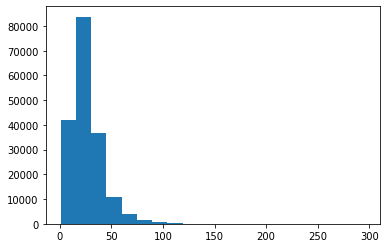

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [ ]:
# What sent len covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Maximum sequence length
np.max(sent_lens)

296

In [ ]:
# From the dataset paper, we know the vocabulary size is 68k
max_tokens = 68000

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocab
                                    output_sequence_length=output_seq_len)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()

In [ ]:
len(rct_20k_text_vocab)

64841

In [ ]:
text_vectorizer(train_sentences[0])

<tf.Tensor: shape=(55,), dtype=int64, numpy=
array([   6,  331,    2,   79,    4,   53,    4,  161, 1127,  217, 2535,
          5,  557,   65, 1584,    3,  670, 5559,  636,    5,    2,  654,
       1137,    3,  180,    2,   70,  495,   36,  781,   15,   53,    5,
        350,  266,    7,  362,    6,  289,  517, 1430, 1743,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])>

### Improved Embedding Layer

In [ ]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), #length of vocabulary
                               output_dim=128,
                               mask_zero=True, #use masking to handle variable sequence lengths (will save space if we have lots of 0s in tensors)
                               name='token_embedding')

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation='softmax')(x)
model_1 = tf.keras.Model(inputs,outputs, name='Conv1D')

# Compile Conv1D model
model_1.compile(loss="categorical_crossentropy", # expects one_hot_encoding
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_1.summary()


# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # make it shorter to save time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"Conv1D")])

Model: "Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_2 (TextVe (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 51, 32)            20512     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 8,320,325
Trainable params: 8,320,325
Non-trainable params: 0
__________________________________________________

In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.5366 - accuracy: 0.8003


[0.5365973711013794, 0.8003442287445068]

In [ ]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs[:10], model_1_pred_probs.shape

(array([[4.5356011e-01, 1.8339011e-01, 1.3820482e-02, 3.4326914e-01,
         5.9601841e-03],
        [3.9887631e-01, 3.4629750e-01, 8.1032846e-04, 2.5313497e-01,
         8.8086905e-04],
        [1.5182404e-01, 1.2331665e-02, 1.1331640e-03, 8.3464891e-01,
         6.2138562e-05],
        [8.7814303e-03, 5.0905799e-03, 9.3877995e-01, 3.2688093e-03,
         4.4079255e-02],
        [3.3531596e-03, 3.1587914e-02, 5.5697030e-01, 3.4295148e-03,
         4.0465912e-01],
        [1.3611651e-03, 1.8081605e-03, 5.0733221e-01, 3.1997700e-04,
         4.8917845e-01],
        [1.4299621e-04, 2.3505788e-03, 1.5105778e-01, 1.1069995e-04,
         8.4633791e-01],
        [5.8381134e-03, 1.4854255e-02, 3.4155825e-01, 4.7433656e-03,
         6.3300610e-01],
        [2.6943271e-05, 1.1172597e-03, 6.2948437e-03, 9.7845696e-06,
         9.9255121e-01],
        [1.6388346e-02, 3.5485810e-01, 1.5134475e-01, 1.2241950e-02,
         4.6516681e-01]], dtype=float32), (30212, 5))

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 80.03442340791739,
 'f1': 0.7984531935000382,
 'precision': 0.7984055119927337,
 'recall': 0.8003442340791739}

Did better than our baseline, likely because there are pretty long sentences, so the deep learning model is able to learn more

## Model 2: Pretrained Universal Sentence Feature Extractor

The paper uses GloVe embeddings, but this isn't on tensorhub so let's try just using the universal sentence encoder

In [ ]:
import tensorflow_hub as hub
# create a keras layer using the Universal Sentence Encoder
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[], #this is blank because USE can take variable lengths
                                        dtype=tf.string,
                                        trainable=False,
                                        name = 'USE')

In [ ]:
inputs = layers.Input(shape=(), dtype='string')
x = sentence_encoder_layer(inputs)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs,outputs)

# Compile Conv1D model
model_2.compile(loss="categorical_crossentropy", # expects one_hot_encoding
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our pretrained model
model_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # make it shorter to save time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"USE_basic")])

Saving TensorBoard log files to: model_logs/USE_basic/20211023-203110
Epoch 1/3
562/562 [==============================] - 16s 23ms/step - loss: 0.9143 - accuracy: 0.6516 - val_loss: 0.7995 - val_accuracy: 0.6905
Epoch 2/3
562/562 [==============================] - 11s 19ms/step - loss: 0.7703 - accuracy: 0.7000 - val_loss: 0.7586 - val_accuracy: 0.7035
Epoch 3/3
562/562 [==============================] - 12s 21ms/step - loss: 0.7559 - accuracy: 0.7103 - val_loss: 0.7434 - val_accuracy: 0.7114


Hmm I have two thoughts on why it didn't perform as well as the Conv1D:

* We are working with scientific text
* Model is pretty simple

### Try the model with basically same set up as model 1 but different embedding

In [ ]:
# create a keras layer using the Universal Sentence Encoder
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[], #this is blank because USE can take variable lengths
                                        dtype=tf.string,
                                        trainable=False,
                                        name = 'USE')

In [ ]:
inputs = layers.Input(shape=(), dtype=tf.string)
x = sentence_encoder_layer(inputs)
x = layers.Reshape(target_shape=(512 , 1 ))(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation='softmax')(x)
model_2_plus = tf.keras.Model(inputs,outputs, name='Conv1D_USE')

# Compile Conv1D model
model_2_plus.compile(loss="categorical_crossentropy", # expects one_hot_encoding
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_2_plus.summary()

Model: "Conv1D_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
reshape (Reshape)            (None, 512, 1)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 508, 32)           192       
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
Total params: 256,798,181
Trainable params: 357
Non-trainable params: 256,797,824
________________________________________

In [ ]:
# Fit the model
model_2_plus_history = model_2_plus.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # make it shorter to save time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"Conv1D_USE")])

Saving TensorBoard log files to: model_logs/Conv1D_USE/20211023-203154
Epoch 1/3
562/562 [==============================] - 16s 24ms/step - loss: 1.4886 - accuracy: 0.3313 - val_loss: 1.4736 - val_accuracy: 0.3298
Epoch 2/3
562/562 [==============================] - 11s 20ms/step - loss: 1.4681 - accuracy: 0.3262 - val_loss: 1.4726 - val_accuracy: 0.3211
Epoch 3/3
562/562 [==============================] - 13s 22ms/step - loss: 1.4705 - accuracy: 0.3329 - val_loss: 1.4725 - val_accuracy: 0.3201


LOL it performed terribly. Maybe I should stick with having dense layers after the encoder

### Denser model

In [ ]:
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[], #this is blank because USE can take variable lengths
                                        dtype=tf.string,
                                        trainable=False,
                                        name = 'USE')

inputs = layers.Input(shape=(), dtype='string')
x = sentence_encoder_layer(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2_denser = tf.keras.Model(inputs,outputs)

# Compile Conv1D model
model_2_denser.compile(loss="categorical_crossentropy", # expects one_hot_encoding
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our pretrained model
model_2_denser.summary()

# Fit the model
model_2_denser_history = model_2_denser.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # make it shorter to save time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"USE_denser")])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 645       
Total params: 256,880,645
Trainable params: 82,821
Non-trainable params: 256,797,824
_________________________________________________________________
Saving TensorBoard log files to: model_logs/USE_denser/20211023-203242
Epoch 1/3
562/562 [================

In [ ]:
# Evaluate
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.2432146167086,
 'f1': 0.7094837586910206,
 'precision': 0.7129445045823091,
 'recall': 0.712432146167086}

## Model 3: Conv1D with character embeddings

The paper uses token+character embeddings. Let's try just character embeddings first

### Create character tokenizer

In [ ]:
','.join(list(train_sentences[0]))

't,o, ,i,n,v,e,s,t,i,g,a,t,e, ,t,h,e, ,e,f,f,i,c,a,c,y, ,o,f, ,@, ,w,e,e,k,s, ,o,f, ,d,a,i,l,y, ,l,o,w,-,d,o,s,e, ,o,r,a,l, ,p,r,e,d,n,i,s,o,l,o,n,e, ,i,n, ,i,m,p,r,o,v,i,n,g, ,p,a,i,n, ,,, ,m,o,b,i,l,i,t,y, ,,, ,a,n,d, ,s,y,s,t,e,m,i,c, ,l,o,w,-,g,r,a,d,e, ,i,n,f,l,a,m,m,a,t,i,o,n, ,i,n, ,t,h,e, ,s,h,o,r,t, ,t,e,r,m, ,a,n,d, ,w,h,e,t,h,e,r, ,t,h,e, ,e,f,f,e,c,t, ,w,o,u,l,d, ,b,e, ,s,u,s,t,a,i,n,e,d, ,a,t, ,@, ,w,e,e,k,s, ,i,n, ,o,l,d,e,r, ,a,d,u,l,t,s, ,w,i,t,h, ,m,o,d,e,r,a,t,e, ,t,o, ,s,e,v,e,r,e, ,k,n,e,e, ,o,s,t,e,o,a,r,t,h,r,i,t,i,s, ,(, ,o,a, ,), ,.'

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

split_chars(random_sentence)

't h e   u s e   o f   i f - t h e n   p l a n s   m i g h t   i m p r o v e   c o m p l i a n c e   w i t h   e l a s t i c   w e a r   w h e n   c o m p a r e d   w i t h   r o u t i n e   c l i n i c a l   i n s t r u c t i o n s   .'

In [ ]:
# Split sequence-level data splits into character level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

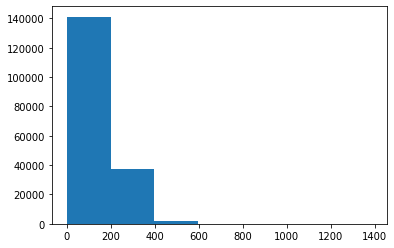

In [ ]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);


In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
random.choice(train_sentences)

'before treatment initiation , telaprevir-resistant variants ( t@a , t@s , or r@k in @ % -@ % of the viral population ) were detected by ds in a fraction ( @ % ) of patients for whom ps failed to detect resistance ; these variants were not necessarily detected at the time of treatment failure .'

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # for space and UNK
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS, 
                                    output_sequence_length=output_seq_char_len,
                                    name='char_vectorizer')

In [ ]:
# Adapt
char_vectorizer.adapt(train_chars)

In [ ]:
# check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
r e m i s s i o n   w a s   d e f i n e d   a s   s c o r e   <   @   o n   t h e   @ - i t e m   b r i e f   s y m p t o m   i n v e n t o r y   (   b s i - @   )   a n x i e t y   a n d   s o m a t i z a t i o n   s u b s c a l e s   .

Length of chars: 99

Vectorized chars:
[[ 8  2 15  4  9  9  4  7  6 20  5  9 10  2 17  4  6  2 10  5  9  9 11  7
   8  2  7  6  3 13  2  4  3  2 15 22  8  4  2 17  9 19 15 14  3  7 15  4
   6 21  2  6  3  7  8 19 22  9  4  5  6 24  4  2  3 19  5  6 10  9  7 15
   5  3  4 25  5  3  4  7  6  9 16 22  9 11  5 12  2  9  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0

In [ ]:
## Creating a character-level embedding
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25, #this is the size of the char embedding in the paper (figure 1)
                              mask_zero=True,
                              name='char_embed')

In [ ]:
# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
r e m i s s i o n   w a s   d e f i n e d   a s   s c o r e   <   @   o n   t h e   @ - i t e m   b r i e f   s y m p t o m   i n v e n t o r y   (   b s i - @   )   a n x i e t y   a n d   s o m a t i z a t i o n   s u b s c a l e s   .

Embedded chars (after vectorization and embedding):
[[[ 0.02471251  0.02205299  0.02959187 ... -0.00851367  0.01212577
    0.01784313]
  [ 0.01846587  0.02974245  0.04111363 ... -0.01215477  0.01485033
   -0.04884307]
  [ 0.04740056  0.03704426  0.04413376 ...  0.03209256 -0.04889314
    0.0120822 ]
  ...
  [-0.02356729 -0.00874382 -0.00355866 ... -0.01476666 -0.00997654
   -0.0111505 ]
  [-0.02356729 -0.00874382 -0.00355866 ... -0.01476666 -0.00997654
   -0.0111505 ]
  [-0.02356729 -0.00874382 -0.00355866 ... -0.01476666 -0.00997654
   -0.0111505 ]]]

Character embedding shape: (1, 290, 25)


### Build Model

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation='softmax')(x)
model_3 = tf.keras.Model(inputs,outputs, name='Conv1D')

# Compile Conv1D model
model_3.compile(loss="categorical_crossentropy", # expects one_hot_encoding
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_3.summary()

Model: "Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 286, 64)           8064      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
__________________________________________________________

In [ ]:
# Need to batch the data - also can prefetch to save time
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

Before we fit this model, do you think that character embeddings would outperform word embeddings?

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 10ms/step - loss: 1.2669 - accuracy: 0.4891 - val_loss: 1.0598 - val_accuracy: 0.5725
Epoch 2/3
562/562 [==============================] - 5s 10ms/step - loss: 1.0159 - accuracy: 0.5943 - val_loss: 0.9561 - val_accuracy: 0.6187
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.9368 - accuracy: 0.6333 - val_loss: 0.8861 - val_accuracy: 0.6513


Character embedding model performed pretty bad, but still better than randomly guessing (a random guess would get ~20% accuracy because there are 5 classes)

It's still mindblowing that the model was able to learn from just characters! 

In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.28200714947702,
 'f1': 0.64432279899778,
 'precision': 0.6475306385224634,
 'recall': 0.6528200714947703}

### Just for fun: trying without char standardization

In [ ]:
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS, 
                                    output_sequence_length=output_seq_char_len,
                                    standardize=None,
                                  name='char_vectorizer')

In [ ]:
# Adapt
char_vectorizer.adapt(train_chars)

In [ ]:
## Creating a character-level embedding
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25, #this is the size of the char embedding in the paper (figure 1)
                              mask_zero=True,
                              name='char_embed')

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation='softmax')(x)
model_3 = tf.keras.Model(inputs,outputs, name='Conv1D')

# Compile Conv1D model
model_3.compile(loss="categorical_crossentropy", # expects one_hot_encoding
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_3.summary()

Model: "Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 286, 64)           8064      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
__________________________________________________________

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 10ms/step - loss: 1.1995 - accuracy: 0.5190 - val_loss: 0.9457 - val_accuracy: 0.6373
Epoch 2/3
562/562 [==============================] - 5s 10ms/step - loss: 0.9032 - accuracy: 0.6426 - val_loss: 0.8520 - val_accuracy: 0.6762
Epoch 3/3
562/562 [==============================] - 5s 10ms/step - loss: 0.8340 - accuracy: 0.6752 - val_loss: 0.7901 - val_accuracy: 0.6945


Interesting! Why do you think it did better?

I think it did better because certain punctuation such as parentheses or colons show up more in like results sections

## Model 4: Pretrained token embeddings + character embeddings

Multimodal models

1. Create token-level embedding (model 2)
2. Create character-level embedding (model 3)
3. Combine 1 & 2 with concatenate layer (`layers.Concatenate`)
4. Add output layers (same as paper)

Here's the paper again: [Neural networks for joint sentence classification in medical paper abstracts](https://arxiv.org/pdf/1612.05251.pdf)

### Building model 

In [ ]:
# Setup token model
token_inputs = layers.Input(shape=[],dtype=tf.string,name='token_input')
token_embeddings = sentence_encoder_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings) # paper uses 300 neurons
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# set up character model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
vectorized_chars = char_vectorizer(char_inputs)
character_embeddings = char_embed(vectorized_chars)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(character_embeddings) #figure 1 says 25 - but let's use 24 for multiple of 8s (faster in tf to use multiples of 8)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# Concatenate token + char
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

# Create output layers - adding in Dropout (see section 4.2 of paper) - also we are skipping the second bi-lstm layer for now
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name='model_4_token_and_char_embeddings')

In [ ]:
model_4.summary() # ew let's visualize this better

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
USE (KerasLayer)                (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

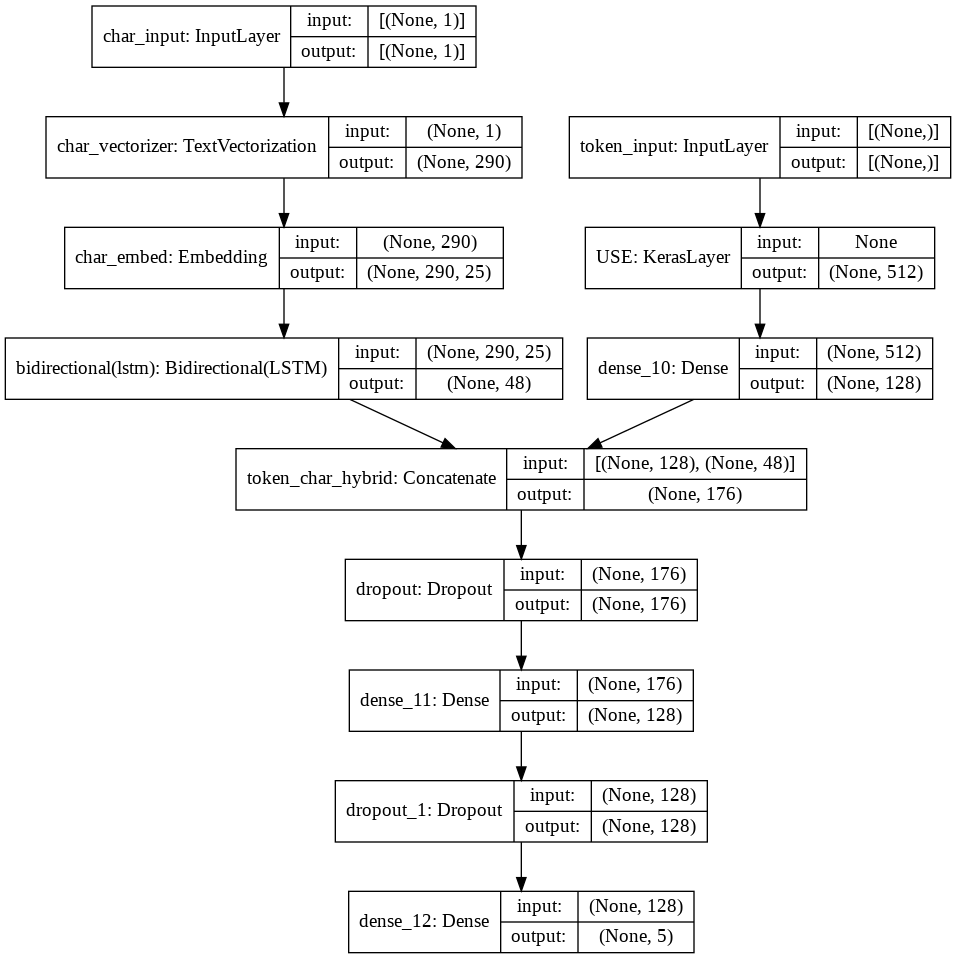

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True) # note:the None is the batch size

In [ ]:
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(), # paper uses SGD
                metrics=['accuracy'])

### Preparing data

Both of these methods work to build the dataset

In [ ]:
# create master tensorflow prefetched batched dataset
train_combined_dataset = tf.data.Dataset.from_tensor_slices(((train_sentences, train_chars), train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_combined_dataset = tf.data.Dataset.from_tensor_slices(((val_sentences, val_chars), val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_combined_dataset

<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Fitting a model on token and character-level sequences

In [ ]:
model_4_history = model_4.fit(train_char_token_dataset,
                              batch_size=32,
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 81s 128ms/step - loss: 0.9841 - accuracy: 0.6071 - val_loss: 0.7766 - val_accuracy: 0.6971
Epoch 2/3
562/562 [==============================] - 69s 122ms/step - loss: 0.7926 - accuracy: 0.6908 - val_loss: 0.7126 - val_accuracy: 0.7261
Epoch 3/3
562/562 [==============================] - 68s 121ms/step - loss: 0.7651 - accuracy: 0.7086 - val_loss: 0.6774 - val_accuracy: 0.7440


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 50s 53ms/step - loss: 0.6838 - accuracy: 0.7418


[0.6837720274925232, 0.7417582273483276]

In [ ]:
# Make predictions with character model only
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

# Convert predictions to classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

# Calculate Conv1D char only model results
model_4_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_4_preds)
model_4_results

{'accuracy': 74.17582417582418,
 'f1': 0.7390042724720391,
 'precision': 0.743936763624673,
 'recall': 0.7417582417582418}

In [ ]:
model_1_results

{'accuracy': 80.03442340791739,
 'f1': 0.7984531935000382,
 'precision': 0.7984055119927337,
 'recall': 0.8003442340791739}

Why do you think it didn't perform as well as model 1? Maybe could try without a pretrained embedding layer?

## Model 5: Pretrained token embeddings + character embeddings + positional (feature) embeddings - the full model from the paper

The order of the sentences are important! For example, generally sentences in the beginning are background/objective sentences

Let's do some feature engineering to add this information into the model!

### Prepare Dataset

In [ ]:
train_df['line_number']/train_df['total_lines']

0         0.000000
1         0.090909
2         0.181818
3         0.272727
4         0.363636
            ...   
180035    0.636364
180036    0.727273
180037    0.818182
180038    0.909091
180039    1.000000
Length: 180040, dtype: float64

In [ ]:
train_positions = train_df['line_number']/train_df['total_lines']
val_positions = val_df['line_number']/val_df['total_lines']

In [ ]:
train_positions_dataset = tf.data.Dataset.from_tensor_slices((train_positions, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_positions_dataset = tf.data.Dataset.from_tensor_slices((val_positions, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

### Build positional model

In [ ]:
train_positions[0].shape

()

In [ ]:
positional_model = tf.keras.Sequential([
                      tf.keras.Input(shape=(1)),
                      tf.keras.layers.Dense(100, activation='relu'),
                      tf.keras.layers.Dense(num_classes, activation='softmax')
])

positional_model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(), # paper uses SGD
                metrics=['accuracy'])

positional_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 505       
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


In [ ]:
positional_model_history = positional_model.fit(train_positions_dataset,
                     epochs=3,
                     validation_data=val_positions_dataset)

Epoch 1/3
5627/5627 [==============================] - 20s 3ms/step - loss: 0.8705 - accuracy: 0.6573 - val_loss: 0.7532 - val_accuracy: 0.6920
Epoch 2/3
5627/5627 [==============================] - 19s 3ms/step - loss: 0.7479 - accuracy: 0.6862 - val_loss: 0.7288 - val_accuracy: 0.6911
Epoch 3/3
5627/5627 [==============================] - 19s 3ms/step - loss: 0.7352 - accuracy: 0.6857 - val_loss: 0.7218 - val_accuracy: 0.6910


### Try different positional model using one-hot

In [ ]:
train_df.line_number.value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

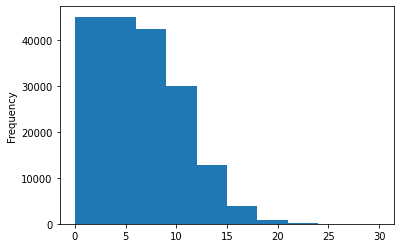

In [ ]:
# Check distribution of line_number column
train_df.line_number.plot.hist()

Let's try with one hot encoding (because line 2 isn't double the size of line 1)

In [ ]:
# One-hot-encoded tensors
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

Let's try keeping total_lines separate

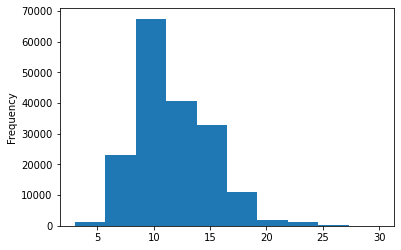

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
np.percentile(train_df.total_lines, 95)

18.0

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### Simple model with just total lines to see what happens

In [ ]:
train_positions_dataset = tf.data.Dataset.from_tensor_slices((train_total_lines_one_hot, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_positions_dataset = tf.data.Dataset.from_tensor_slices((val_total_lines_one_hot, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
positional_model2 = tf.keras.Sequential([
                      tf.keras.Input(shape=(20,)),
                      tf.keras.layers.Dense(100, activation='relu'),
                      tf.keras.layers.Dense(num_classes, activation='softmax')
])

positional_model2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(), # paper uses SGD
                metrics=['accuracy'])

positional_model2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 100)               2100      
_________________________________________________________________
dense_33 (Dense)             (None, 5)                 505       
Total params: 2,605
Trainable params: 2,605
Non-trainable params: 0
_________________________________________________________________


In [ ]:
positional_model2_history = positional_model2.fit(train_positions_dataset,
                                                  epochs=3,
                                                  validation_data=val_positions_dataset)

Epoch 1/3
5627/5627 [==============================] - 20s 4ms/step - loss: 1.4668 - accuracy: 0.3331 - val_loss: 1.4639 - val_accuracy: 0.3349
Epoch 2/3
5627/5627 [==============================] - 19s 3ms/step - loss: 1.4648 - accuracy: 0.3351 - val_loss: 1.4634 - val_accuracy: 0.3349
Epoch 3/3
5627/5627 [==============================] - 19s 3ms/step - loss: 1.4643 - accuracy: 0.3356 - val_loss: 1.4632 - val_accuracy: 0.3349


### Tri-input model

1. Create token model
2. Create character-level model
3. Create line number model
4. Create total_lines model
5. Concatenate 1 & 2
6. Concatenate 3,4,5 
7. Create output layer to accept output from 6 and output label probabilities

In [ ]:
train_total_lines_one_hot.dtype

tf.float32

In [ ]:
# Setup token model
token_inputs = layers.Input(shape=[],dtype=tf.string,name='token_input')
token_embeddings = sentence_encoder_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings) # paper uses 300 neurons
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# set up character model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
vectorized_chars = char_vectorizer(char_inputs)
character_embeddings = char_embed(vectorized_chars)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(character_embeddings) #figure 1 says 25 - but let's use 24 for multiple of 8s (faster in tf to use multiples of 8)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# Line number model
line_number_model = tf.keras.Sequential([
                      tf.keras.Input(shape=(15,), dtype=tf.float32),
                      tf.keras.layers.Dense(32, activation='relu')
                      #tf.keras.layers.Dense(num_classes, activation='softmax') - this goes at the end of our giant combined model
])
# Total lines model
total_lines_model = tf.keras.Sequential([
                      tf.keras.Input(shape=(20,), dtype=tf.float32),
                      tf.keras.layers.Dense(32, activation='relu')
                      #tf.keras.layers.Dense(num_classes, activation='softmax') - this goes at the end of our giant combined model
])

# Concatenate token + char
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])
token_char_concat_dropout = layers.Dropout(0.5)(token_char_concat)

# Concatenate token_char + line number + total_lines
token_char_lines_total_concat = layers.Concatenate(name='concat_all')([token_char_concat_dropout, line_number_model.output, total_lines_model.output])

# Create output layers - adding in Dropout (see section 4.2 of paper) - also we are skipping the second bi-lstm layer for now
combined_dense = layers.Dense(128, activation='relu')(token_char_lines_total_concat)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

model_5 = tf.keras.Model(inputs=[token_model.input, char_model.input, line_number_model.input, total_lines_model.input],
                         outputs=output_layer,
                         name='model_5_tribrid')

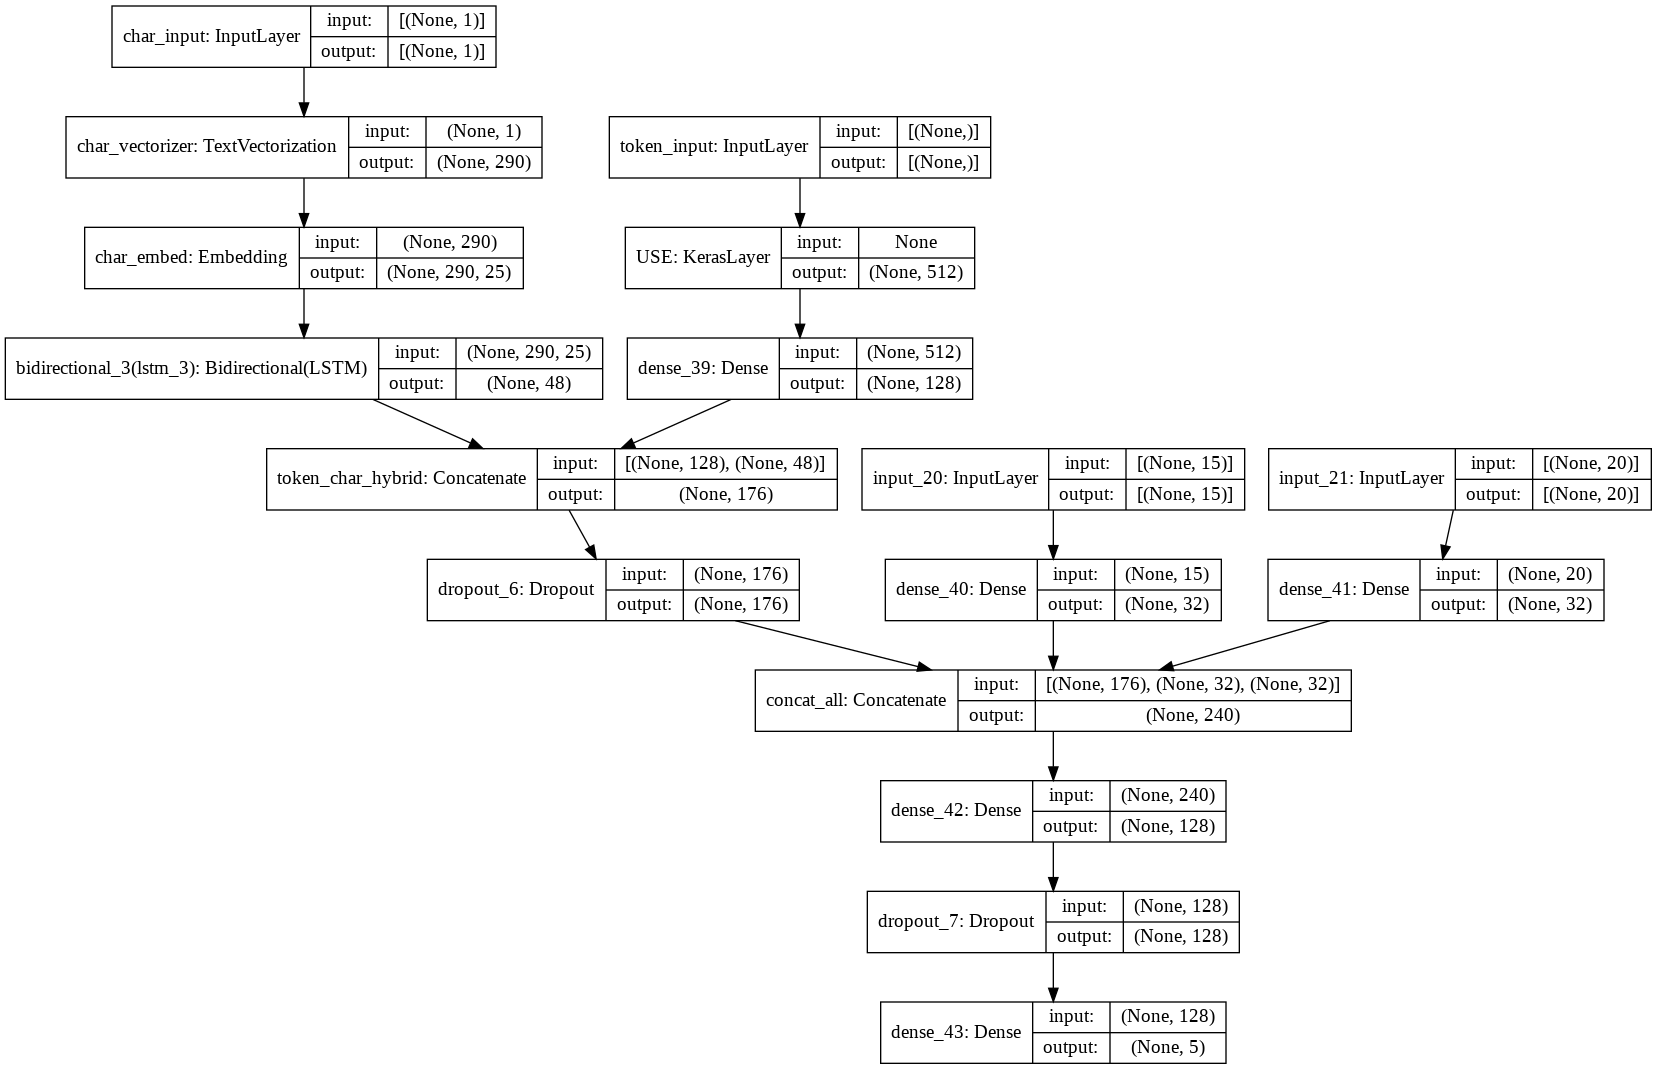

In [ ]:
plot_model(model_5, show_shapes=True)

In [ ]:
# Compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

What is label smoothing? Stops model from predicting 100% to a certain class - instead spreading out some of the % into other classes

So instead of `[0, 0, 1]`

the model predicts `[0.01, 0.01, .98]` which helps it to generalize better!

See this article:
https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

Note: they custom build label smoothing

### Prepare datasets

In [ ]:
# model is expecting tokens, chars, line numbers, total lines
train_tribrid_dataset = tf.data.Dataset.from_tensor_slices(((train_sentences, 
                                                               train_chars, 
                                                               train_line_numbers_one_hot, 
                                                               train_total_lines_one_hot), train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_tribrid_dataset = tf.data.Dataset.from_tensor_slices(((val_sentences, 
                                                             val_chars, 
                                                             val_line_numbers_one_hot, 
                                                             val_total_lines_one_hot), val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_tribrid_dataset

<PrefetchDataset shapes: (((None,), (None,), (None, 15), (None, 20)), (None, 5)), types: ((tf.string, tf.string, tf.float32, tf.float32), tf.float64)>

### Fitting and evaluating model

In [ ]:
model_5_history = model_5.fit(train_tribrid_dataset,
                              batch_size=32,
                              epochs=3,
                              validation_data=val_tribrid_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 83s 130ms/step - loss: 1.1057 - accuracy: 0.7095 - val_loss: 0.9559 - val_accuracy: 0.8185
Epoch 2/3
562/562 [==============================] - 70s 124ms/step - loss: 0.9746 - accuracy: 0.8129 - val_loss: 0.9233 - val_accuracy: 0.8414
Epoch 3/3
562/562 [==============================] - 69s 123ms/step - loss: 0.9544 - accuracy: 0.8225 - val_loss: 0.9084 - val_accuracy: 0.8464


In [ ]:
# Make predictions with character model only
model_5_pred_probs = model_5.predict(val_tribrid_dataset)
model_5_pred_probs

# Convert predictions to classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

# Calculate Conv1D char only model results
model_5_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_5_preds)
model_5_results

{'accuracy': 84.58228518469483,
 'f1': 0.8448239122661433,
 'precision': 0.8446666850792777,
 'recall': 0.8458228518469483}

In [ ]:
# It beat our best model - model 1
model_1_results

{'accuracy': 80.03442340791739,
 'f1': 0.7984531935000382,
 'precision': 0.7984055119927337,
 'recall': 0.8003442340791739}

In [ ]:
# Beat our character + embedding model by like 10%
model_4_results

{'accuracy': 74.17582417582418,
 'f1': 0.7390042724720391,
 'precision': 0.743936763624673,
 'recall': 0.7417582417582418}

Ideas for further experiments:

* Try different positional model setups
* Copy the paper exactly and have a second bidirectional LSTM layer
* Try GloVe instead of USE
* Tune different hyperparameters (label smoothing, increase neurons, different depths of one hot encodings, etc.)
* Try adding more layers
* Fine tune USE layer

## Comparing model results

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,80.034423,0.798406,0.800344,0.798453
pretrained_token_embed,71.243215,0.712945,0.712432,0.709484
custom_char_embed_conv1d,65.282007,0.647531,0.652820,0.644323
hybrid_char_token_embed,74.175824,0.743937,0.741758,0.739004
tribrid_embed,84.582285,0.844667,0.845823,0.844824


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

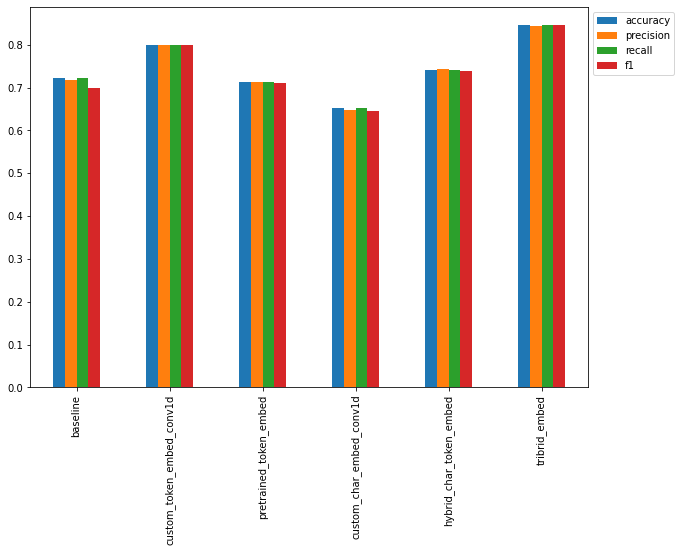

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

Note: Could've used tensorboard to compare

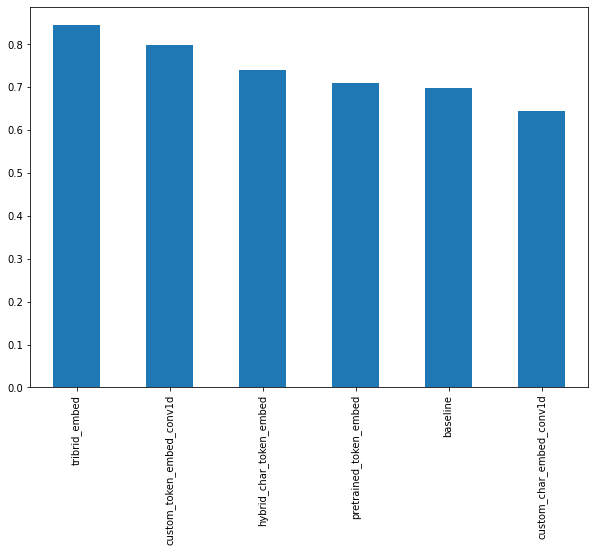

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

The authors model achieves an F1-score of 90.0 on the 20k RCT dataset versus our F1-score of ~84)

There are some things to note about this difference:

* Our models (with an exception for the baseline) have been trained on 10% of the data
* We evaluated on validation set, not test set

### Saving model

In [ ]:
model_5.save('organize_medical_abstracts_best_model')

INFO:tensorflow:Assets written to: organize_medical_abstracts_best_model/assets


INFO:tensorflow:Assets written to: organize_medical_abstracts_best_model/assets


In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model('organize_medical_abstracts_best_model')

ValueError: ignored

In [ ]:
Hmm the problem has to do with the `mask_zero=True` we can fix it by removing that 

## Conclusion

Well that was a long notebook

Additional things to add:

* Looking at model's worst predictions
* Fitting on all training+valid data and then evaluating on test data
* Grabbing our own abstract and seeing how the model performs on it

Additional Future Project:

* Can we add a button that let's you evaluate if the predictions were good or bad? Then the model can learn from human evaluations